# First of All

| Name          | Ridwan Halim     |
|---------------|------------------|
| Student ID    | 5210411257       |
| Course        | Soft Computing   |

## 📦 Import Dependencies

In [54]:
import folium
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from math import radians, sin, cos, sqrt, atan2

## 📍 Load capital

data of coordinates (latitude, longitude), capital city names, and province names.

In [27]:
capital = pd.read_csv('data/capital.csv')
capital.head()

,province,capital,latitude,longitude
0,Aceh,Banda Aceh,5.55,95.32
1,Sumatera Utara,Medan,3.58,98.67
2,Sumatera Barat,Padang,-0.94,100.36
3,Riau,Pekanbaru,0.54,101.44
4,Jambi,Jambi,-1.60,103.61


## 📏 Check the length of the data

In [28]:
print(len(capital))

38


# Initial Map Locations

## 🚀 Set Center Coordinates and Zoom Start

In [38]:
map_center = [capital['latitude'].mean(), capital['longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=4)

## 🏙️ Add markers for each city

In [39]:
for _, row in capital.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['capital']}, {row['province']}",
    ).add_to(my_map)

## 🌍 Display the map

In [40]:
display(my_map)

# Setting Up Solutions

## 📏 Haversine formula

Calculate the distance between two points

In [59]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the Earth in km

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

def calculate_distances(capital):
    n_cities = len(capital)
    distances = np.zeros((n_cities, n_cities))
    for i in range(n_cities):
        for j in range(n_cities):
            if i != j:
                distances[i][j] = haversine(capital.latitude[i], capital.longitude[i], capital.latitude[j], capital.longitude[j])
    return distances

def annotate_km(data, **kws):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j + 0.5, i + 0.5, f'{data[i, j]:.0f} km', ha='center', va='center', color='white')

In [60]:
# calculate distances
distances = calculate_distances(capital)
print(distances[10:16, 10:16]) # print the first 5x5 submatrix

[[  0.         116.86387579 407.23588814 430.28878745 665.16257259
   74.60268441]
 [116.86387579   0.         311.39222252 321.10258909 569.5398012
  182.69488794]
 [407.23588814 311.39222252   0.          90.23648427 258.70628214
  481.51029586]
 [430.28878745 321.10258909  90.23648427   0.         269.39700626
  501.83141917]
 [665.16257259 569.5398012  258.70628214 269.39700626   0.
  739.63019814]
 [ 74.60268441 182.69488794 481.51029586 501.83141917 739.63019814
    0.        ]]


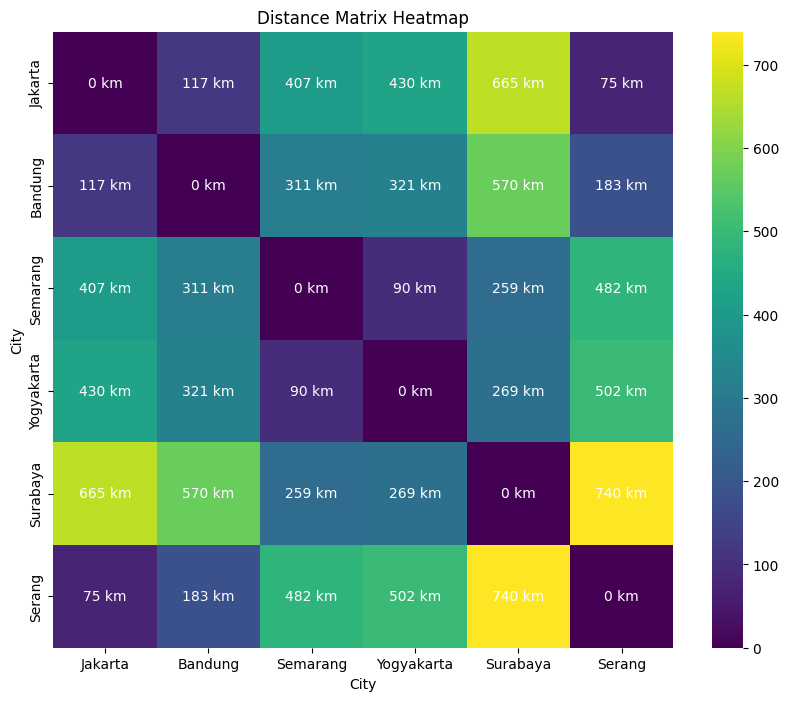

In [61]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(distances[10:16, 10:16], cmap='viridis', annot=False, xticklabels=capital['capital'][10:16], yticklabels=capital['capital'][10:16])
annotate_km(distances[10:16, 10:16])
plt.title('Distance Matrix Heatmap')
plt.xlabel('City')
plt.ylabel('City')
plt.show()

## 🐜 Ant Colony Optimizer

In [62]:
class AntColonyOptimizer:
    def __init__(
        self, distances, n_ants, n_iterations, decay_rate=0.5, alpha=1, beta=5, q=1
    ):
        self.distances = distances  # distance matrix
        self.n_cities = len(distances)  # number of cities
        self.n_ants = n_ants  # number of ants
        self.n_iterations = n_iterations  # number of iterations
        self.decay_rate = decay_rate  # evaporation rate
        self.alpha = alpha  # influence of pheromone
        self.beta = beta  # influence of distance
        self.q = q  # pheromone deposit amount constant

        self.pheromone = np.ones((self.n_cities, self.n_cities))
        self.best_path = None
        self.best_path_length = float("inf")

    def _select_next_city(self, current_city, visited):
        unvisited = np.where(visited == False)[0]
        probabilities = []
        total_prob = 0

        for city in unvisited:
            eta = (
                1 / self.distances[current_city][city]
                if self.distances[current_city][city] > 0
                else 0
            )
            tau = self.pheromone[current_city][city]
            prob = (tau**self.alpha) * (eta**self.beta)
            probabilities.append(prob)
            total_prob += prob

        if total_prob == 0:
            return random.choice(unvisited)

        probabilities = np.array(probabilities) / total_prob
        return np.random.choice(unvisited, p=probabilities)

    def _move_ant(self, start_city):
        current_city = start_city
        visited = np.zeros(self.n_cities, dtype=bool)
        visited[current_city] = True
        path = [current_city]

        for _ in range(self.n_cities - 1):
            next_city = self._select_next_city(current_city, visited)
            path.append(next_city)
            visited[next_city] = True
            current_city = next_city

        # Return to the starting city
        path.append(start_city)
        return path

    def _calculate_path_length(self, path):
        length = 0
        for i in range(len(path) - 1):
            length += self.distances[path[i]][path[i + 1]]
        return length

    def _update_pheromones(self, paths):
        self.pheromone *= 1 - self.decay_rate  # pheromone evaporation

        for path in paths:
            path_length = self._calculate_path_length(path)
            for i in range(len(path) - 1):
                delta_pheromone = self.q / path_length if path_length > 0 else 0
                self.pheromone[path[i]][path[i + 1]] += delta_pheromone

    def optimize(self):
        for i in range(self.n_iterations):
            paths = []
            for _ in range(self.n_ants):
                start_city = random.randint(0, self.n_cities - 1)
                paths.append(self._move_ant(start_city))

            self._update_pheromones(paths)

            for path in paths:
                path_length = self._calculate_path_length(path)
                if path_length < self.best_path_length:
                    self.best_path = path
                    self.best_path_length = path_length
            if i % 5 == 0:
                print(f"Iteration {i+1}: Best path length = {self.best_path_length}")
        return self.best_path

In [20]:
# ACO
n_ants = 40
n_iterations = 200
aco = AntColonyOptimizer(distances, n_ants, n_iterations)
best_path = aco.optimize()

Iteration 1: Best path length = 16291.672429174685
Iteration 6: Best path length = 16015.340231716558
Iteration 11: Best path length = 15786.586503536922
Iteration 16: Best path length = 15125.54359981583
Iteration 21: Best path length = 14983.423165091292
Iteration 26: Best path length = 14983.423165091292
Iteration 31: Best path length = 14983.423165091292
Iteration 36: Best path length = 14982.44280753167
Iteration 41: Best path length = 14982.44280753167
Iteration 46: Best path length = 14982.44280753167
Iteration 51: Best path length = 14982.44280753167
Iteration 56: Best path length = 14892.692551876738
Iteration 61: Best path length = 14892.692551876738
Iteration 66: Best path length = 14892.692551876738
Iteration 71: Best path length = 14892.692551876738
Iteration 76: Best path length = 14892.692551876738
Iteration 81: Best path length = 14892.692551876738
Iteration 86: Best path length = 14892.692551876738
Iteration 91: Best path length = 14892.692551876738
Iteration 96: Best 

## 🌟 Visualize and Display Sequence of Visited Capital Cities

In [63]:
def visualize_path(capital, path, map_center):
    my_map = folium.Map(location=map_center, zoom_start=5)
    points = [(capital.latitude[i], capital.longitude[i]) for i in path]
    folium.PolyLine(points, weight=3, color='red').add_to(my_map)

    for i, city_index in enumerate(path):
         city = capital.iloc[city_index]
         folium.Marker([city['latitude'], city['longitude']], popup=f"{city['capital']} ({i+1})").add_to(my_map)
    
    return my_map

def display_result(capital, best_path):
    print("Sequence of visited capital cities:")
    for i, city_index in enumerate(best_path):
       print(f"{i+1}. {capital.capital[city_index]}")

In [64]:
# visualize the best path
map_center = [capital['latitude'].mean(), capital['longitude'].mean()]

result_map = visualize_path(capital, best_path, map_center)
display(result_map)

In [65]:
# Sequence of visited capital cities
display_result(capital, best_path)

Sequence of visited capital cities:
1. Banda Aceh
2. Medan
3. Pekanbaru
4. Tanjung Pinang
5. Jambi
6. Palembang
7. Pangkal Pinang
8. Pontianak
9. Palangkaraya
10. Banjarmasin
11. Samarinda
12. Tanjung Selor
13. Palu
14. Mamuju
15. Makassar
16. Kendari
17. Gorontalo
18. Manado
19. Sofifi
20. Sorong
21. Manokwari
22. Nabire
23. Jayawijaya
24. Jayapura
25. Merauke
26. Ambon
27. Kupang
28. Mataram
29. Denpasar
30. Surabaya
31. Semarang
32. Yogyakarta
33. Bandung
34. Jakarta
35. Serang
36. Bandar Lampung
37. Bengkulu
38. Padang
39. Banda Aceh


# Hyperparameter Optimization